In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import pandas as pd
from sqlalchemy import create_engine

# Paramètres pour la connexion à SQL Server
server = 'DIRAR'
database = 'DATA WAREHOUSE'
username = 'sa'
password = 'azerty123'

# Création du moteur SQLAlchemy pour SQL Server
engine = create_engine(
    f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
)

# Charger les tables nécessaires dans des DataFrames pandas
dim_admission = pd.read_sql("SELECT * FROM dim_admission", engine)
dim_patients = pd.read_sql("SELECT * FROM dim_patients", engine)
dim_doctor = pd.read_sql("SELECT * FROM dim_doctor", engine)
dim_reclamation = pd.read_sql("SELECT * FROM dim_reclamation", engine)
dim_temps = pd.read_sql("SELECT * FROM dim_temps", engine)
satisfaction_fact = pd.read_sql("SELECT * FROM satisfaction_fact", engine)

# Affichage de quelques lignes pour vérifier
print(dim_admission.head())
print(dim_patients.head())

   hadm_id admission_type         admission_location        discharge_location
0   100375      EMERGENCY  TRANSFER FROM HOSP/EXTRAM                       SNF
1   100969      EMERGENCY       EMERGENCY ROOM ADMIT              DEAD/EXPIRED
2   101361      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  REHAB/DISTINCT PART HOSP
3   103379      EMERGENCY       EMERGENCY ROOM ADMIT          HOME HEALTH CARE
4   103770      EMERGENCY       EMERGENCY ROOM ADMIT  REHAB/DISTINCT PART HOSP
   subject_id insurance language  religion marital_status  \
0       10006  Medicare           CATHOLIC      SEPARATED   
1       10011   Private           CATHOLIC         SINGLE   
2       10013  Medicare           CATHOLIC                  
3       10017  Medicare           CATHOLIC       DIVORCED   
4       10019  Medicare           CATHOLIC       DIVORCED   

                ethnicity  
0  BLACK/AFRICAN AMERICAN  
1   UNKNOWN/NOT SPECIFIED  
2   UNKNOWN/NOT SPECIFIED  
3                   WHITE  
4                  

In [8]:
satisfaction_fact = pd.read_sql("SELECT Reclamation_ID, Resolution_Duration_Days FROM satisfaction_fact", engine)
dim_reclamation = pd.read_sql("SELECT Reclamation_ID, Status FROM dim_reclamation", engine)

print("First few rows of satisfaction_fact:")
print(satisfaction_fact.head())
print("\nFirst few rows of dim_reclamation:")
print(dim_reclamation.head())

First few rows of satisfaction_fact:
  Reclamation_ID  Resolution_Duration_Days
0           rec1                        15
1          rec10                        12
2          rec11                        18
3          rec12                        26
4          rec13                        22

First few rows of dim_reclamation:
  Reclamation_ID    Status
0           rec1  Resolved
1          rec10  Resolved
2          rec11  Resolved
3          rec12   Pending
4          rec13   Pending


In [12]:
merged_df = pd.merge(satisfaction_fact, dim_reclamation, on='Reclamation_ID', how='inner')
print("\nFirst few rows of the merged DataFrame:")
print(merged_df.head())


First few rows of the merged DataFrame:
  Reclamation_ID  Resolution_Duration_Days    Status
0           rec1                        15  Resolved
1          rec10                        12  Resolved
2          rec11                        18  Resolved
3          rec12                        26   Pending
4          rec13                        22   Pending


In [14]:
df_status = merged_df[['Resolution_Duration_Days', 'Status']].copy()
df_status.dropna(inplace=True)

# Encode the 'Status' column
label_encoder = LabelEncoder()
df_status['Status_Encoded'] = label_encoder.fit_transform(df_status['Status'])

print("\nDataFrame with encoded Status:")
print(df_status.head())
print("\nUnique values in Status and their encodings:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


DataFrame with encoded Status:
   Resolution_Duration_Days    Status  Status_Encoded
0                        15  Resolved               1
1                        12  Resolved               1
2                        18  Resolved               1
3                        26   Pending               0
4                        22   Pending               0

Unique values in Status and their encodings:
{'Pending': 0, 'Resolved': 1}


In [16]:
X = df_status[['Resolution_Duration_Days']]
y = df_status['Status_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (16, 1)
Shape of X_test: (4, 1)
Shape of y_train: (16,)
Shape of y_test: (4,)


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_encoded = model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)


--- Classification Report (Predicting Status by Resolution Duration) ---
Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

     Pending       0.00      0.00      0.00         0
    Resolved       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



C:\Users\bdrdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bdrdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bdrdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


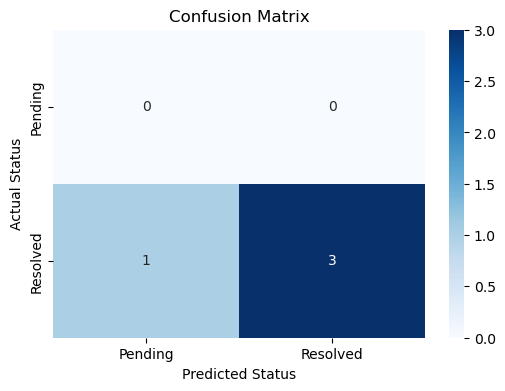

In [22]:
accuracy = accuracy_score(y_test_original, y_pred)
print("\n--- Classification Report (Predicting Status by Resolution Duration) ---")
print(f'Accuracy: {accuracy}')
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix')
plt.show()